# Running in parallel

Running with multiple jobs is a good idea. this could be done at multiple levels (i.e., sending different jobs for different vertices). We can also get some speed gains by passing a pool to emcee

To run in parallel the system will pickle the objects. this introduces a speed cost - the larger the object to pickle the slower you will be. If you can set things to be available globally this should speed stuff up. Setting things globally could also be a problem later...

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
try:
    from prfpy.stimulus import PRFStimulus2D
    from prfpy.model import Iso2DGaussianModel
except:
    from prfpy_csenf.stimulus import PRFStimulus2D
    from prfpy_csenf.model import Iso2DGaussianModel
import os
import yaml
import pickle
from datetime import datetime

# If you already have the design matrix as a numpy array, you can simply load it...
dm = np.load('./design_matrix.npy') #[:,:,5:]
prf_stim = PRFStimulus2D(
    screen_size_cm=39.3,          # Distance of screen to eye
    screen_distance_cm=196,  # height of the screen (i.e., the diameter of the stimulated region)
    design_matrix=dm,                                   # dm (npix x npix x time_points)
    TR=1.5,                                  # TR
    )
# Now we can make the model
model = 'gauss'
# HRF is determined by coefficients for the canonical HRF, its time derivative, and its dispersion derivative
# Here we set it at 1, 4.6 and 0 (what we have found to work at spinoza)
prfpy_model = Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0]) 

# Load the runs
psc_runs = np.load('eg_data.npy')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parallel - microprobing

In [66]:
# Some starting positions... (a bit random - but lets go for it for now)
pol = np.linspace(0, 2*np.pi, 14)
ecc = np.array([1, 2.5, 5]) # , 2,3, 4,])
pol,ecc = np.meshgrid(pol, ecc)
x,y = ecc*np.cos(pol), ecc*np.sin(pol)
x,y = x.flatten(), y.flatten()
walkers = np.array([x,y]).T
# -> need to specify the "move", i.e., how it makes steps
import emcee 
moves = emcee.moves.GaussianMove(cov=.5, mode='vector') # Setting cov=.1 for a small step size


In [62]:
# Apparently this can interfere if not set to 1
os.environ['OMP_NUM_THREADS'] = '1'

### test timing

In [14]:
from prfpy_bayes.micro_probe import MicroProbe #, PrfpyModelGlobal, prfpy_global_model
n_steps = 100

In [ ]:

# n_steps = 100 # Small number of steps for starting...
# time_start = datetime.now()
# bprf_serial = MicroProbe(
#     prfpy_model = prfpy_model,  # prfpy model objects
#     real_ts = psc_runs,         # time series (data)
#     bounds = [-5,5],            # bounds for x,y
#     tiny_prf_size = 0.01,       # tiny prf size     
# )

# time_start = datetime.now()
# bprf_serial.run_mcmc_fit(
#     idx=0,                      # Index of the vertex times series to fit     
#     n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
#     walkers=walkers,            # Starting points
#     n_steps=n_steps,                # How many steps to takes
#     kwargs_sampler={'moves':moves},  # Arguments for the sampler
#     kwargs_run = {'skip_initial_state_check':True, },        
# )
# t1 = datetime.now()-time_start
# print(f'Time taken: {t1}')


In [71]:
# *************************************************************

n_steps = 200
time_start = datetime.now()
bprf_par = MicroProbe(
    prfpy_model = prfpy_model,  # prfpy model objects
    real_ts = psc_runs,         # time series (data)
    bounds = [-5,5],            # bounds for x,y
    tiny_prf_size = 0.01,       # tiny prf size     
)
# Same again but wiht multiprocessing
import multiprocessing
time_start = datetime.now()
# from prfpy_bayes.micro_probe import prfpy_global_model
# from prfpy_bayes.micro_probe import prfpy_global_model
from prfpy_bayes.micro_probe import prfpy_global_model
with multiprocessing.Pool(
    len(walkers), 
    # initializer=init_global_model
    ) as pool:
    # So it can be accessed globally!!
    # from prfpy_bayes.micro_probe import prfpy_global_model
    prfpy_global_model.set_model(prfpy_model)
    bprf_par.run_mcmc_fit(
        idx=0,                      # Index of the vertex times series to fit     
        n_walkers=len(walkers),     # Number of walkers (i.e., starting points)
        walkers=walkers,            # Starting points
        n_steps=n_steps,                # How many steps to takes
        kwargs_sampler={'moves':moves},  # Arguments for the sampler
        kwargs_run = {'skip_initial_state_check':True, 'tune':True,}, #  'progress':'notebook'},        
        pool=pool,
    )

t2 = datetime.now()-time_start
print(f'{t2}')


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)


Running in parallel


/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/data1/projects/dumoulinlab/Lab_members/Marcus/programs/prfpy_bayes/prfpy_bayes/micro_probe.py:327: RuntimeWarning: invalid value encountered in scalar divide
  slope = np.sum((response - m_response) * (pred - m_pred)) / np.sum((pred - m_pred) **2)
/dat

prf_params.shape[-1]=8
include hrf = True
include rsq = True
0:00:19.310211


In [72]:
idx = 0
n_walkers = len(walkers)
n_timepts = n_steps
walker_step_xy = np.zeros((n_walkers, n_timepts, 2))
walker_step_rsq = np.zeros((n_walkers, n_timepts))
for iw in range(n_walkers):
    vx_mask = bprf_par.sampler[idx].return_vx_mask(th={'eq-walker_id':iw})
    x = bprf_par.sampler[idx].pd_params['x'][vx_mask].to_numpy()
    y = bprf_par.sampler[idx].pd_params['y'][vx_mask].to_numpy()
    rsq = bprf_par.sampler[idx].pd_params['rsq'][vx_mask].to_numpy()
    step_id = bprf_par.sampler[idx].pd_params['step_id'][vx_mask].to_numpy()


    # Ensure the data is sorted by step_id
    sorted_indices = np.argsort(step_id)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    rsq_sorted = rsq[sorted_indices]

    # Fill the walker_step_xy array
    walker_step_xy[iw, :, 0] = x_sorted
    walker_step_xy[iw, :, 1] = y_sorted
    walker_step_rsq[iw, :] = rsq_sorted


500

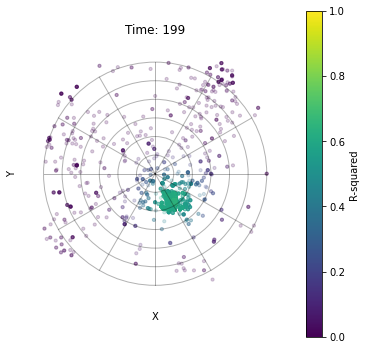

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example Data (replace this with your actual data)
n_walkers = walker_step_xy.shape[0]
n_timepts = walker_step_xy.shape[1]
# walker_step_xy = np.random.rand(n_walkers, n_timepts, 2) * 20 - 10  # Random positions
# walker_step_rsq = np.random.rand(n_walkers, n_timepts)  # Random R-squared values (e.g., for color)

# Normalize walker_step_rsq for consistent color scaling
rsq_min, rsq_max = 0, 1  # Adjust these based on your data range

# Toggle for showing past points
show_past = True

# Setup the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter([], [], s=20, cmap='viridis', c=[], vmin=rsq_min, vmax=rsq_max, edgecolors='k', alpha=1.0)  # Current points
past_sc = ax.scatter([], [], s=10, cmap='viridis', c=[], vmin=rsq_min, vmax=rsq_max, alpha=0.2)  # Past points
# Add colour bar
cbar = plt.colorbar(sc, ax=ax, label="R-squared")
# Set axis limits (adjust based on your data)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
from dag_prf_utils.plot_functions import *
dag_add_ecc_pol_lines(ax=plt.gca())
# dag_add_
ax.set_title("Point Movements Over Time")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Update function for animation
def update(frame):
    if show_past:
        # Flatten the past points and colors
        past_positions = walker_step_xy[:, :frame, :].reshape(-1, 2)
        past_colors = walker_step_rsq[:, :frame].flatten()

        # Update past scatter plot
        past_sc.set_offsets(past_positions)
        past_sc.set_array(past_colors)

    # Update current points
    sc.set_offsets(walker_step_xy[:, frame, :])
    sc.set_array(walker_step_rsq[:, frame])
    sc.set_alpha(1.0)  # Ensure current points are opaque

    # Update the title
    ax.set_title(f"Time: {frame}")
    return sc, past_sc if show_past else sc,

# Create animation
ani = FuncAnimation(fig, update, frames=n_timepts, interval=100, blit=True)

# Save the animation or display it
# Uncomment the line below to save the animation as a video or GIF
ani.save("scatter_movie_with_past_points_TUNEpt5.mp4", writer="ffmpeg")

plt.show()

# DN

In [90]:
from prfpy_csenf.model import Norm_Iso2DGaussianModel
dn_model = Norm_Iso2DGaussianModel(stimulus=prf_stim, hrf=[1, 4.6, 0])
from prfpy_bayes.prf_bayes import BayesPRF
# Start by making the bprf objects
Nbprf = BayesPRF(
    prf_params=None, # We could put in our best guess here, but we will let the model figure it out...
    model = 'norm',
    prfpy_model=dn_model,
    real_ts=psc_runs,
    )
Nbounds = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0.1, 10],
    'amp_1': [0, 100],
    'size_2' : [0.1, 10],
    'amp_2' : [0, 100],
    'b_val' : [0, 100],
    'd_val' : [0, 100],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [4.6, 4.6], # Not going to fit the HRF, we have enough to deal with...
    'hrf_disp' : [0, 0],
}

Nbprf.add_priors_from_bounds(Nbounds)
Nbprf.prep_info()
print(Nbprf.init_p_id)

prf_params.shape[-1]=12
include hrf = True
include rsq = True
{'x': 0, 'y': 1, 'size_1': 2, 'amp_1': 3, 'amp_2': 4, 'size_2': 5, 'b_val': 6, 'd_val': 7}


In [280]:
# *************************************************************

initial_guess = [
    0, # x
    0, # y
    1, # size_1
    2, # amp_1
    1, # amp_2
    2, # size_2
    1, # b_val
    10, # d_val
]
idx  = 25
n_walkers = 30
n_steps = 500
# Same again but wiht multiprocessing
import multiprocessing
time_start = datetime.now()
# from prfpy_bayes.micro_probe import prfpy_global_model
# from prfpy_bayes.micro_probe import prfpy_global_model

from prfpy_bayes.prf_bayes import prfpy_global_model
with multiprocessing.Pool(
    20, 
    # initializer=init_global_model
    ) as pool:
    # So it can be accessed globally!!
    # from prfpy_bayes.micro_probe import prfpy_global_model
    prfpy_global_model.set_model(dn_model)
    Nbprf.run_mcmc_fit(
        initial_guess=initial_guess, 
        idx=idx,                      # Index of the vertex times series to fit     
        n_walkers=n_walkers, 
        n_steps=n_steps,                # How many steps to takes
        pool=pool,
        eps=.1,
    )

t2 = datetime.now()-time_start
print(f'{t2}')


Running in parallel
prf_params.shape[-1]=12
include hrf = True
include rsq = True
0:01:18.881022


In [282]:
idx = 0
n_timepts = n_steps
p2find = ['size_1', 'size_2', 'amp_1', 'amp_2', 'b_val', 'd_val']
w_id = {}
for p in p2find + ['x', 'y', 'rsq']:
    w_id[p] = np.zeros((n_walkers, n_timepts))
    for iw in range(n_walkers):
        vx_mask = Nbprf.sampler[idx].return_vx_mask(th={'eq-walker_id':iw})
        if vx_mask.sum()==0:
            print(iw)
            continue
        step_id = Nbprf.sampler[idx].pd_params['step_id'][vx_mask].to_numpy()
        this_p = Nbprf.sampler[idx].pd_params[p][vx_mask].to_numpy()

        # Ensure the data is sorted by step_id
        sorted_indices = np.argsort(step_id)
        w_id[p][iw,:] = this_p[sorted_indices].copy()


RuntimeError: The animation function must return a sequence of Artist objects.

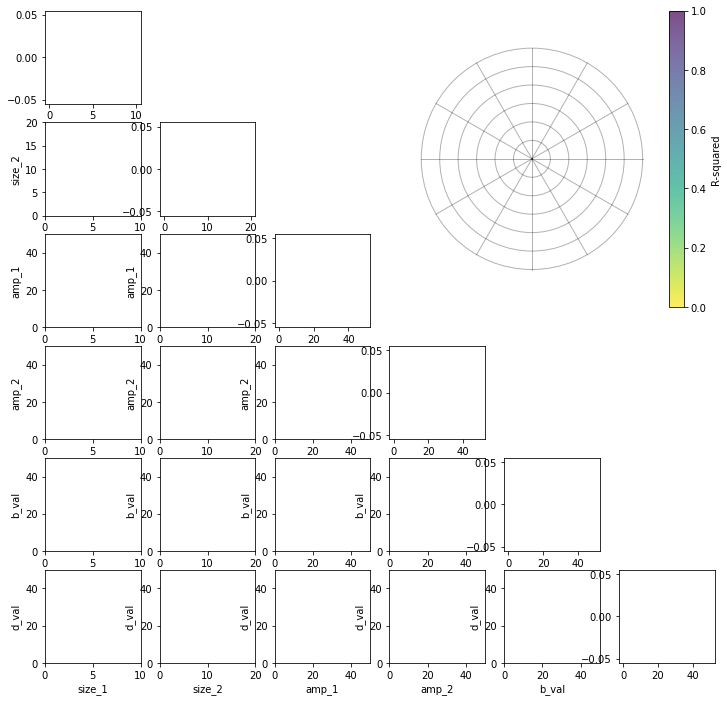

In [ ]:
Nbounds_plot = {
    'x': [-5, 5],
    'y': [-5, 5],
    'size_1': [0, 10],
    'amp_1': [0, 50],
    'size_2' : [0, 20],
    'amp_2' : [0, 50],
    'b_val' : [0, 50],
    'd_val' : [0, 50],
    'bold_baseline': [0, 0],
    'hrf_deriv' : [4.6, 4.6], # Not going to fit the HRF, we have enough to deal with...
    'hrf_disp' : [0, 0],
}
p4ax = len(p2find)
fig, axs = plt.subplots(p4ax, p4ax, figsize=(2*p4ax, 2*p4ax))
xy_ax = fig.add_subplot(2,2,2)
xy = xy_ax.scatter([], [], s=10, cmap='viridis_r', c=[], vmin=0, vmax=1, alpha=.7)  # Current points
cbar = plt.colorbar(xy, ax=xy_ax, label="R-squared")
sc = {}
hs = {}
for iR,pr in enumerate(p2find):
    sc[pr] = {}
    for iC,pc in enumerate(p2find):

        if iR<iC:
            axs[iR,iC].axis('off')
        elif iR==iC:
            axs[iR,iC].set_xlim(Nbounds_plot[pc])
            axs[iR,iC].set_xlabel(pc)
            hs[pr] = axs[iR,iC]
        else:
            sc[pr][pc] = axs[iR,iC].scatter([], [], s=10, cmap='viridis_r', c=[], vmin=0, vmax=1, alpha=.7)  # Current points
            axs[iR,iC].set_xlim(Nbounds_plot[pc])
            axs[iR,iC].set_xlabel(pc)
            axs[iR,iC].set_ylim(Nbounds_plot[pr])
            axs[iR,iC].set_ylabel(pr)
        # if iC==0:
        #     axs[iR,iC].set_ylabel(pr)
        # else:
        #     axs[iR,iC].set_yticks([])
        # if iR==len(p2find)-1:
        #     axs[iR,iC].set_xlabel(pc)
        # else: 
        #     axs[iR,iC].set_xticks([])
            # bloop
dag_add_ecc_pol_lines(xy_ax)


# ANIMATE
# Update function for animation
def update_plots(frame):
    for pr in sc.keys():
        bins = np.linspace(Nbounds_plot[pr][0], Nbounds_plot[pr][1], 20)
        hs[pr].clear()
        hs[pr].hist(w_id[pr][:,:frame].flatten(), bins=bins)
        if sc[pr]=={}:
            continue        
        for pc in sc[pr].keys():
            this_xy = np.column_stack(
                [w_id[pc][:,:frame].flatten(),w_id[pr][:,:frame].flatten()]
            )                
            sc[pr][pc].set_offsets(
                this_xy
            )
            sc[pr][pc].set_array(
                w_id['rsq'][:,:frame].flatten(),
            )
    # Update current points
    this_xy = np.column_stack(
        [w_id['x'][:,:frame].flatten(),w_id['y'][:,:frame].flatten()]
    )
    xy.set_offsets(this_xy)
    xy.set_array(
        w_id['rsq'][:,:frame].flatten(),
    ) 
    # print(frame)   
    # sc.set_offsets(walker_step_xy[:, frame, :])
    # sc.set_array(walker_step_rsq[:, frame])
    # sc.set_alpha(1.0)  # Ensure current points are opaque

    # Update the title
    # fig.suptitle(f"Time: {frame}")
    fig.canvas.draw()
    return sc, xy,hs

# Create animation
# update_plots(0)
ani = FuncAnimation(fig, update_plots, frames=500, interval=100, blit=True)

# Save the animation or display it
# Uncomment the line below to save the animation as a video or GIF
ani.save("bayes_DN_movie.mp4", writer="ffmpeg")

plt.show()

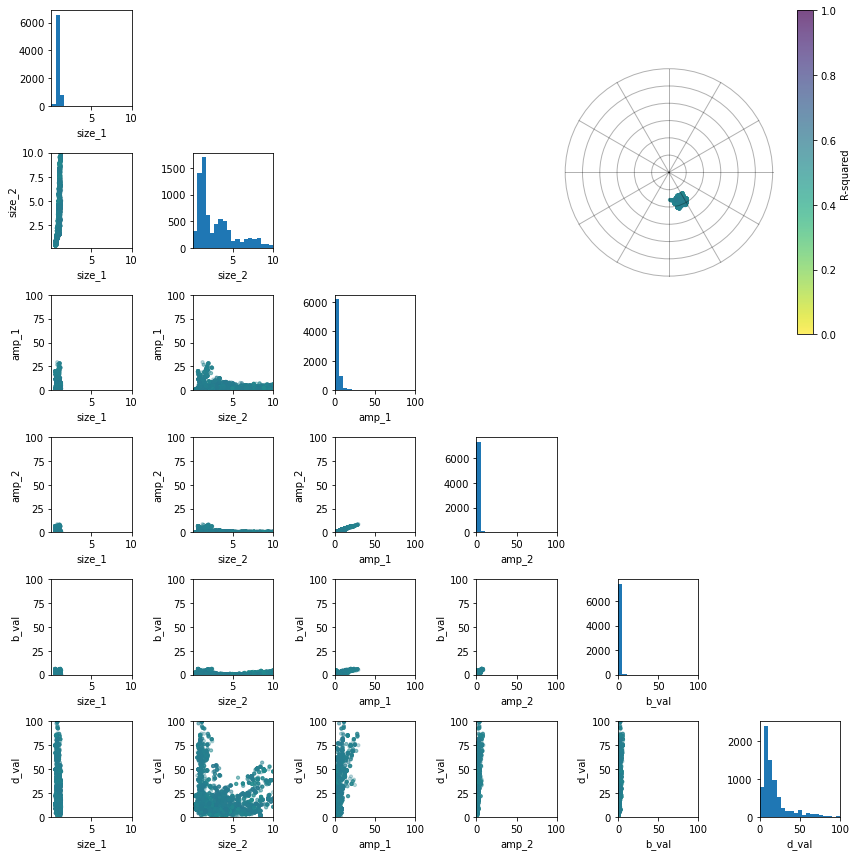

In [281]:
# Final
Nbounds_plot = Nbounds
p4ax = len(p2find)
fig, axs = plt.subplots(p4ax, p4ax, figsize=(2*p4ax, 2*p4ax))
xy_ax = fig.add_subplot(2,2,2)
pth2plot = Nbprf.sampler[idx].return_th_params(
    p2find + ['x', 'y', 'rsq'],
    th={
        'min-rsq':0, 
        'min-step_id':250, }
)
xy = xy_ax.scatter(
    pth2plot['x'], pth2plot['y'], 
    s=10, cmap='viridis_r', c=pth2plot['rsq'], vmin=0, vmax=1, alpha=.7)  # Current points
cbar = plt.colorbar(xy, ax=xy_ax, label="R-squared")
sc = {}
hs = {}
for iR,pr in enumerate(p2find):
    sc[pr] = {}
    for iC,pc in enumerate(p2find):
        if iR<iC:
            axs[iR,iC].axis('off')
        elif iR==iC:
            axs[iR,iC].set_xlim(Nbounds_plot[pr])
            bins = np.linspace(Nbounds_plot[pr][0], Nbounds_plot[pr][1], 20)
            axs[iR,iC].hist(pth2plot[pr], bins=bins)
            axs[iR,iC].set_xlabel(pr)

        else:
            axs[iR,iC].scatter(
                pth2plot[pc], pth2plot[pr],
                s=10, cmap='viridis_r', 
                c=pth2plot['rsq'], 
                vmin=0, vmax=1, alpha=.3)  # Current points
            axs[iR,iC].set_xlim(Nbounds_plot[pc])
            axs[iR,iC].set_ylim(Nbounds_plot[pr])
            axs[iR,iC].set_xlabel(pc)
            axs[iR,iC].set_ylabel(pr)
        # # if iC==0:
        #     axs[iR,iC].set_xlabel(pc)
        # else:
        #     axs[iR,iC].set_yticks([])
        # if iR==len(p2find)-1:
        #     axs[iR,iC].set_ylabel(pr)
        # else: 
        #     axs[iR,iC].set_xticks([])
            # bloop
dag_add_ecc_pol_lines(xy_ax)
fig.set_tight_layout(True)


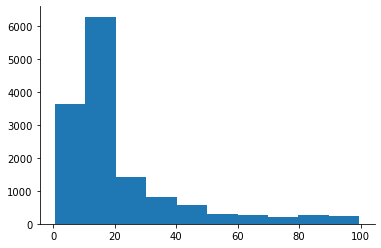

In [263]:
Nbprf.sampler[idx].hist('d_val')

In [258]:
import pandas
pdth = pandas.DataFrame(pth2plot)

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

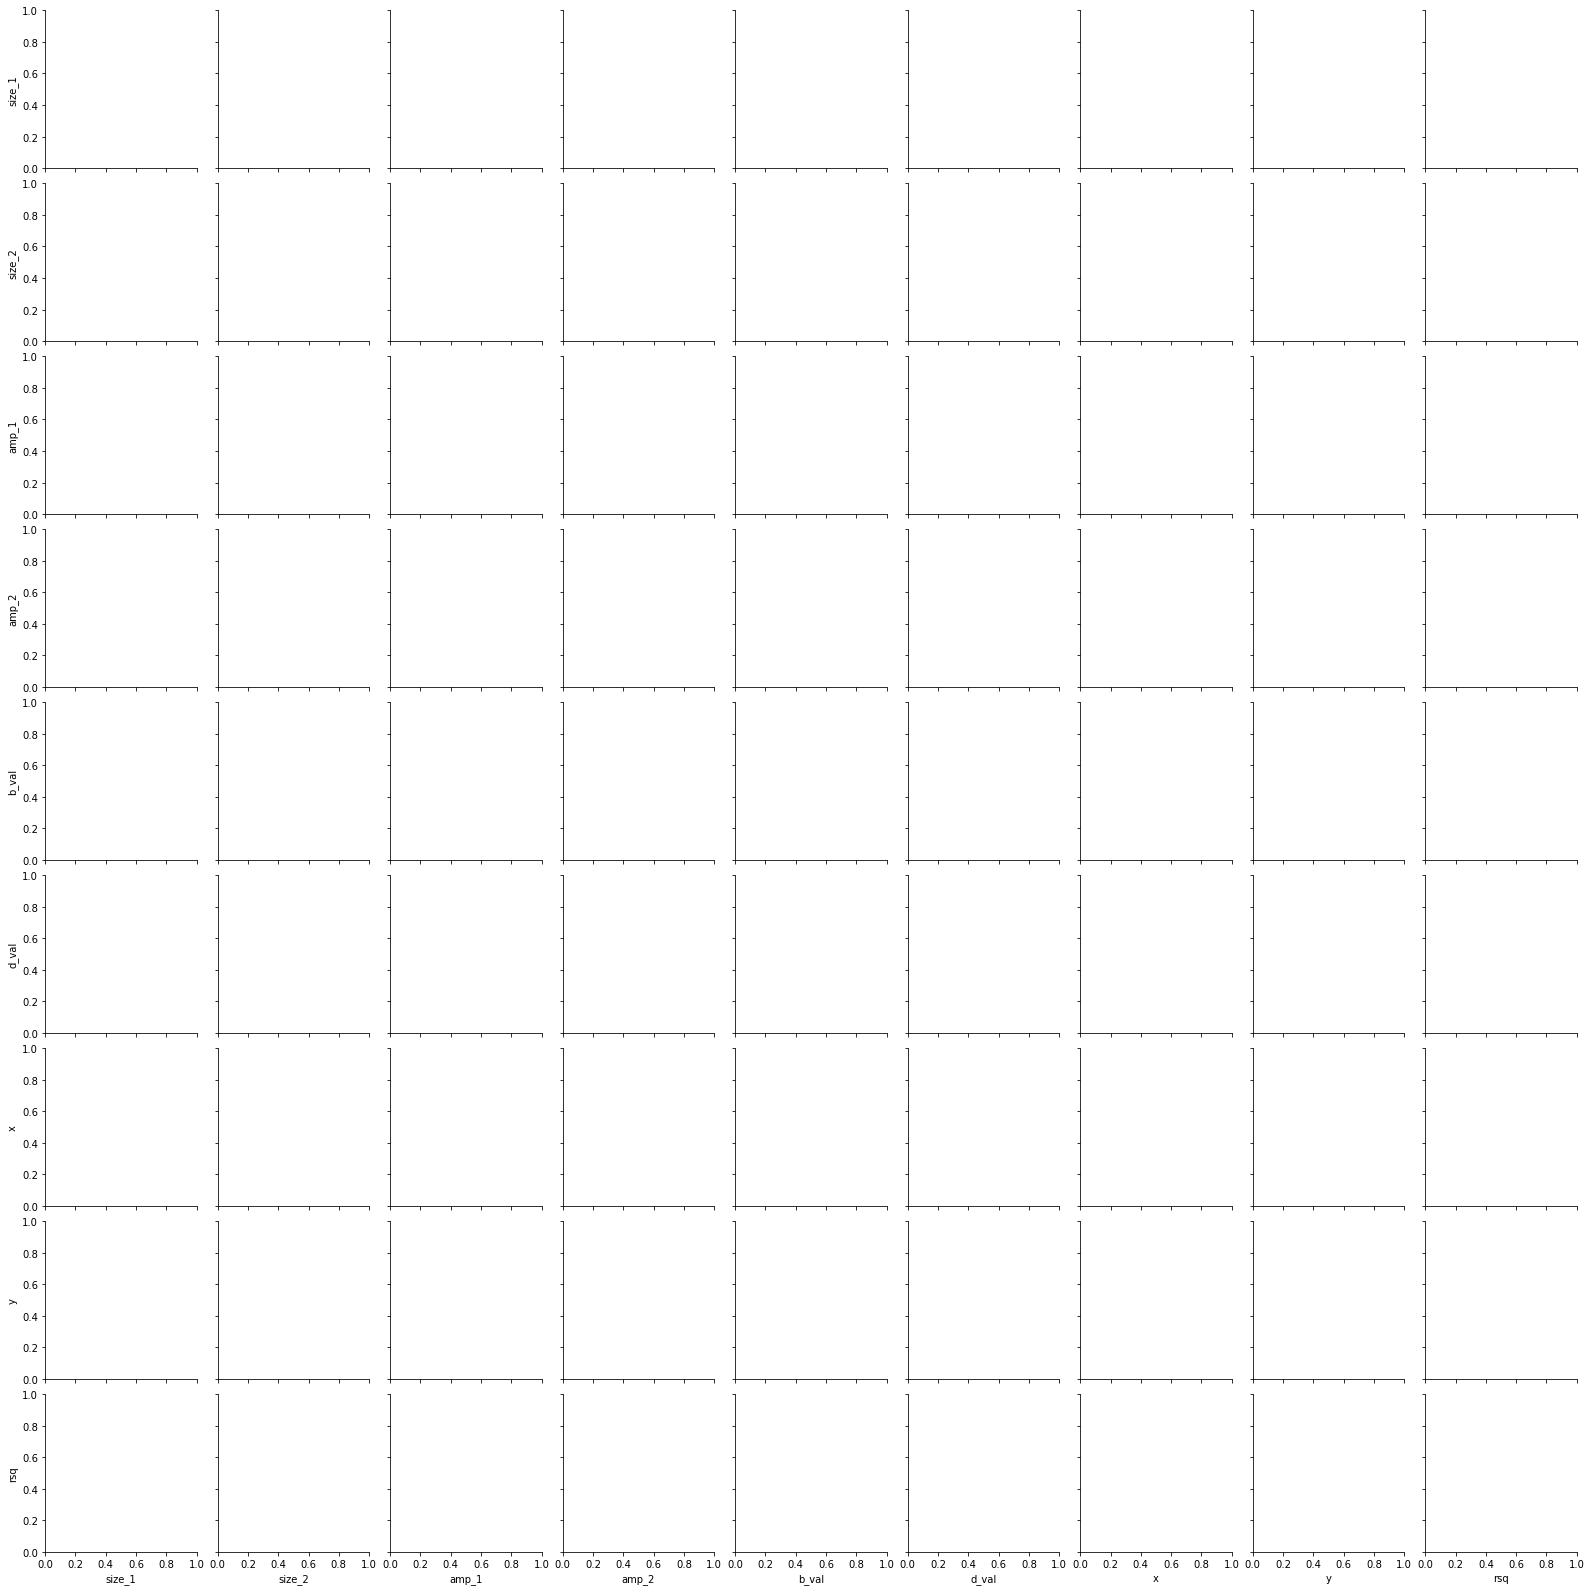

In [260]:
g = sns.PairGrid(pdth)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

In [146]:
frame = 1
w_id[pc][:,:frame].flatten()

array([ 9.99998516,  9.99994065, 10.00020243, 10.00004476, 10.00001451,
        9.99996611, 10.00028986, 10.00002614, 10.00001449, 10.00000288,
        9.99996165, 10.00006244,  9.99977402,  9.99986307, 10.00010579,
        9.99994771,  9.99973806, 10.00013131,  9.99999573, 10.00000637,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [140]:
sc

{'size_1': {},
 'size_2': {'size_1': <matplotlib.collections.PathCollection at 0x7f938cb8fb50>},
 'amp_1': {'size_1': <matplotlib.collections.PathCollection at 0x7f93877f85b0>,
  'size_2': <matplotlib.collections.PathCollection at 0x7f938d858dc0>},
 'amp_2': {'size_1': <matplotlib.collections.PathCollection at 0x7f938cbace50>,
  'size_2': <matplotlib.collections.PathCollection at 0x7f938cbac760>,
  'amp_1': <matplotlib.collections.PathCollection at 0x7f938c5b4ee0>},
 'b_val': {'size_1': <matplotlib.collections.PathCollection at 0x7f938c46fd30>,
  'size_2': <matplotlib.collections.PathCollection at 0x7f938faa2340>,
  'amp_1': <matplotlib.collections.PathCollection at 0x7f938c4cb1f0>,
  'amp_2': <matplotlib.collections.PathCollection at 0x7f938c4cb490>},
 'd_val': {'size_1': <matplotlib.collections.PathCollection at 0x7f938c4cbe50>,
  'size_2': <matplotlib.collections.PathCollection at 0x7f938798a9a0>,
  'amp_1': <matplotlib.collections.PathCollection at 0x7f9390f32550>,
  'amp_2': <matp

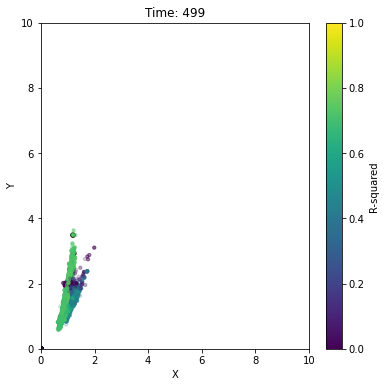

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Example Data (replace this with your actual data)
n_walkers = walker_step_xy.shape[0]
n_timepts = walker_step_xy.shape[1]
# walker_step_xy = np.random.rand(n_walkers, n_timepts, 2) * 20 - 10  # Random positions
# walker_step_rsq = np.random.rand(n_walkers, n_timepts)  # Random R-squared values (e.g., for color)

# Normalize walker_step_rsq for consistent color scaling
rsq_min, rsq_max = 0, 1  # Adjust these based on your data range

# Toggle for showing past points
show_past = True

# Setup the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter([], [], s=20, cmap='viridis', c=[], vmin=rsq_min, vmax=rsq_max, edgecolors='k', alpha=1.0)  # Current points
past_sc = ax.scatter([], [], s=10, cmap='viridis', c=[], vmin=rsq_min, vmax=rsq_max, alpha=0.2)  # Past points
# Add colour bar
cbar = plt.colorbar(sc, ax=ax, label="R-squared")
# Set axis limits (adjust based on your data)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
from dag_prf_utils.plot_functions import *
# dag_add_ecc_pol_lines(ax=plt.gca())
# dag_add_
ax.set_title("Point Movements Over Time")
ax.set_xlabel("X")
ax.set_ylabel("Y")

# Update function for animation
def update(frame):
    if show_past:
        # Flatten the past points and colors
        past_positions = walker_step_xy[:, :frame, :].reshape(-1, 2)
        past_colors = walker_step_rsq[:, :frame].flatten()

        # Update past scatter plot
        past_sc.set_offsets(past_positions)
        past_sc.set_array(past_colors)

    # Update current points
    sc.set_offsets(walker_step_xy[:, frame, :])
    sc.set_array(walker_step_rsq[:, frame])
    sc.set_alpha(1.0)  # Ensure current points are opaque

    # Update the title
    ax.set_title(f"Time: {frame}")
    return sc, past_sc if show_past else sc,

# Create animation
ani = FuncAnimation(fig, update, frames=n_timepts, interval=100, blit=True)

# Save the animation or display it
# Uncomment the line below to save the animation as a video or GIF
ani.save("scatter_movie_with_past_points_NS.mp4", writer="ffmpeg")

plt.show()